In [184]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
sv = survey('data/survey2/')

In [186]:
sv.num_processor()

In [187]:
df = sv.fin_data

### split

In [188]:
dfc = df.copy()

y = dfc.pop('employed').values
X = dfc.values

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)

## Random Forest

In [190]:
rf=RandomForestClassifier(n_jobs = -1)
scores = cross_val_score(rf,X,y,n_jobs=-1,scoring='roc_auc')
np.mean(scores)

0.77239536741890202

In [191]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

[[273 233]
 [230 739]]


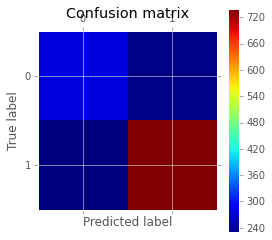

In [192]:
plot_confusion_matrix(rf,X_test,y_test)

roc_auc_score : 0.725931749858


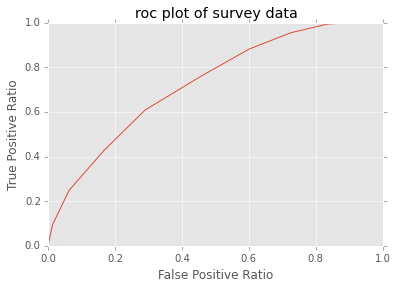

In [193]:
plot_roc(rf,X_test,y_test)


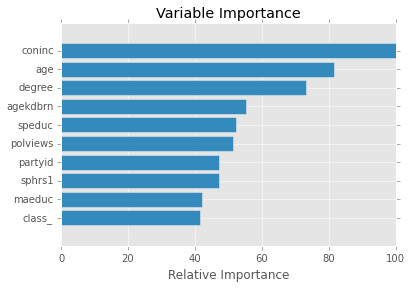

In [194]:
plot_importance(rf,dfc)

# shrink the size

In [195]:
f = rf.feature_importances_.argsort()

In [197]:
clis = dfc.columns

In [214]:
dfs = df[clis[f]].copy()

In [208]:
X=dfs.values

In [215]:
rf = RandomForestClassifier()

In [216]:
roclis = []
for i in f:
    if dfs.shape[1]==1:
        break
    dfs.drop(clis[i],axis = 1, inplace =True)
    X = dfs.values
    scores = cross_val_score(rf,X,y,cv = 10, scoring='roc_auc',n_jobs=-1)
    roclis.append(np.mean(scores))


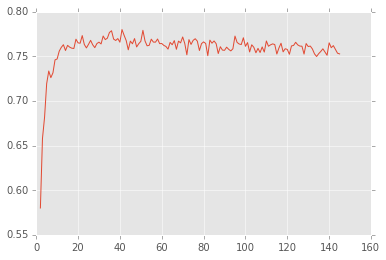

In [217]:
plt.plot(range(145,1,-1),roclis)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)

In [69]:
rfs = RandomForestClassifier()
rfs.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

[[309 197]
 [233 736]]


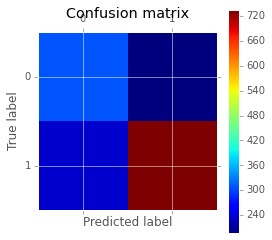

In [70]:
plot_confusion_matrix(rfs,X_test,y_test)

roc_auc_score : 0.741556431185


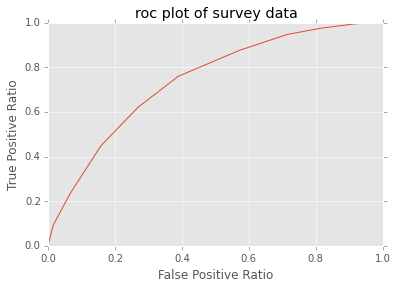

In [71]:
plot_roc(rfs,X_test,y_test)

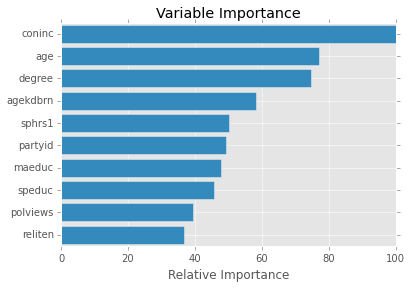

In [52]:
plot_importance(rfs,df_s)

In [59]:
df_s.columns

Index([u'coninc', u'age', u'agekdbrn', u'degree', u'sphrs1', u'partyid',
       u'class_', u'maeduc', u'res16', u'paeduc', u'incom16', u'speduc',
       u'reliten', u'polviews', u'socfrend', u'finrela', u'dwelling',
       u'natroad', u'divorce', u'fund', u'marital', u'mobile16', u'satfin',
       u'pillok', u'natsoc', u'natfare', u'fechld', u'mawrkgrw', u'socbar',
       u'fefam', u'dwelown', u'natpark', u'natarms', u'natspac', u'meovrwrk',
       u'fepresch', u'chldidel', u'natcity', u'helpnot', u'racdif4',
       u'natdrug', u'kidssol', u'postlife', u'conbus', u'cappun', u'obey',
       u'wrkwayup', u'workhard', u'coop', u'discaff', u'parsol', u'parborn',
       u'happy', u'hapmar', u'conclerg', u'helpoth', u'helpsick', u'letdie1',
       u'consci', u'trust', u'coneduc', u'uswary', u'nateduc', u'thnkself',
       u'natcrime', u'conjudge', u'natrace', u'contv', u'spkcom', u'abnomore',
       u'helppoor', u'courts', u'spkmil', u'spanking', u'homosex', u'goodlife',
       u'conlegis', 